<a href="https://www.kaggle.com/code/iamamir/used-cars-purchase?scriptVersionId=118957740" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Scenario**
> A US used-car-dealership company buys used-cars cheaply in online auctions and from other car sellers in order to then resell them profitably on their own platform. It's not always easy to tell if a used car is worth buying: one of the biggest challenges with used car auctions is the risk of a car having serious problems that prevent it from being resold to customers. These are so-called "lemon cars" - that is, cars that come out of the box with significant defects due to manufacturing errors that significantly affect the safety, use, or value of that car, and at the same time not in a reasonable number of repairs or within a given period can be remedied. In this case, the customer has the right to have the purchase price refunded. In addition to the acquisition costs, the wrong purchase of such "lemon cars" leads to considerable follow-up costs, such as the storage and repair of the car, which can result in losses when the vehicle is resold.

> That's why it's important to the company to rule out as many bad purchases of "lemon cars" as possible. In order to relieve the buyers in the company with the huge number of offers, a model should be developed that predicts whether an offer would be a bad buy in the sense of a lemon car. However, this must not lead to too many good purchases being excluded. 



# 1) Dataset Description 

In [1]:
# Import and read data dictionary to get familiar with data coumn names and their description.
import pandas as pd 
data_dict = pd.read_csv('/kaggle/input/used-cars-purchase-data-dict/used_cars_purchase_data_dict.csv', index_col = 'Column No.')
data_dict

,Column name,Description
Column No.,,
1,'RefID',Unique (sequential) number assigned to vehicles
2,'IsBadBuy',Identifies if the kicked vehicle was an avoida...
3,'PurchDate',The Date the vehicle was Purchased at Auction
4,'Auction',Auction provider at which the vehicle was purc...
5,'VehYear',The manufacturer's year of the vehicle
6,'VehicleAge',The Years elapsed since the manufacturer's year
7,'Make',Vehicle Manufacturer
8,'Model',Vehicle Model
9,'Trim',Vehicle Trim Level


# 2) Define Metric 
 With our understanding of the problem, we should now consider which metric(s) are best suited to assess the success of our model.

1. Recall: Percentage of vehicles correctly predicted as lemon cars relative to all actual lemon cars.
2. Precision: Percentage of vehicles correctly predicted as lemon cars relative to all correct predictions.
3. F1 Score: Weighted harmonic mean of precision and recall.

## Goal
Exclude as many bad purchases of "lemon cars" as possible. Minimize the false negative rate, i.e. the maximum recall.
However, this should not mean that too many good purchases are excluded (minimum false positive). **The false positive rate must not be too high either. The f1 score takes into account both miss rates and is the metric we are looking for.**

# 3) Gather Data
The data is in the data_train.csv file. The target vector is given by the 'IsBadBuy' column. Here the modules that typically is needed for reading and exploration is imported and then is read in pandas DataFrame df_train.

In [2]:
#Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.2f}'.format

In [3]:
#Read data
df_train = pd.read_csv('/kaggle/input/carvana/training_car.csv')

# Copy initial dataframe (df_train)
# for further data processing comparison 
df_init = df_train.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

# 4) Exploratory Data Analysis (EDA)
### Understand Data
It is necessary to familiarize with the data at the beginning so that we know later what to look for while cleaning and preparing the data.

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Check first five rows of data
df_train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.00,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.00,9829.00,11636.00,13600.00,7451.00,8552.00,11597.00,12409.00,NaN,NaN,21973,33619,FL,7100.00,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.00,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.00,8383.00,10897.00,12572.00,7456.00,9222.00,11374.00,12791.00,NaN,NaN,19638,33619,FL,7600.00,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.00,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.00,4760.00,6943.00,8457.00,4035.00,5557.00,7146.00,8702.00,NaN,NaN,19638,33619,FL,4900.00,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.00,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.00,2675.00,4658.00,5690.00,1844.00,2646.00,4375.00,5518.00,NaN,NaN,19638,33619,FL,4100.00,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.00,Covers,69367,AMERICAN,COMPACT,FORD,3913.00,5054.00,7723.00,8707.00,3247.00,4384.00,6739.00,7911.00,NaN,NaN,19638,33619,FL,4000.00,0,1020


In [5]:
#check describe
df_train.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.00,72983.00,72983.00,72983.00,69814.00,72983.00,72965.00,72965.00,72965.00,72965.00,72668.00,72668.00,72668.00,72668.00,72983.00,72983.00,72983.00,72983.00,72983.00
mean,36511.43,0.12,2005.34,4.18,1.49,71500.00,6128.91,7373.64,8497.03,9850.93,6132.08,7390.68,8775.72,10145.39,26345.84,58043.06,6730.93,0.03,1276.58
std,21077.24,0.33,1.73,1.71,0.52,14578.91,2461.99,2722.49,3156.29,3385.79,2434.57,2686.25,3090.70,3310.25,25717.35,26151.64,1767.85,0.16,598.85
min,1.00,0.00,2001.00,0.00,0.00,4825.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,835.00,2764.00,1.00,0.00,462.00
25%,18257.50,0.00,2004.00,3.00,1.00,61837.00,4273.00,5406.00,6280.00,7493.00,4275.00,5414.00,6536.00,7784.00,17212.00,32124.00,5435.00,0.00,837.00
50%,36514.00,0.00,2005.00,4.00,1.00,73361.00,6097.00,7303.00,8444.00,9789.00,6062.00,7313.00,8729.00,10103.00,19662.00,73108.00,6700.00,0.00,1155.00
75%,54764.50,0.00,2007.00,5.00,2.00,82436.00,7765.00,9021.00,10651.00,12088.00,7736.00,9013.00,10911.00,12309.00,22808.00,80022.00,7900.00,0.00,1623.00
max,73014.00,1.00,2010.00,9.00,3.00,115717.00,35722.00,36859.00,39080.00,41482.00,35722.00,36859.00,39080.00,41062.00,99761.00,99224.00,45469.00,1.00,7498.00


In [6]:
# Determine different datatype column names

# Datetime
date_time = ['PurchDate']

# Categorical data
cat_cols = ['IsBadBuy','Auction','Make','Model','Trim','SubModel','Color','Transmission','WheelTypeID','WheelType',
           'Nationality','Size','TopThreeAmericanName','PRIMEUNIT','AUCGUART','BYRNO','VNZIP1','VNST','IsOnlineSale']

# Numerical data
num_cols = ['VehYear','VehicleAge','VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice',
           'MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice',
           'VehBCost','WarrantyCost']

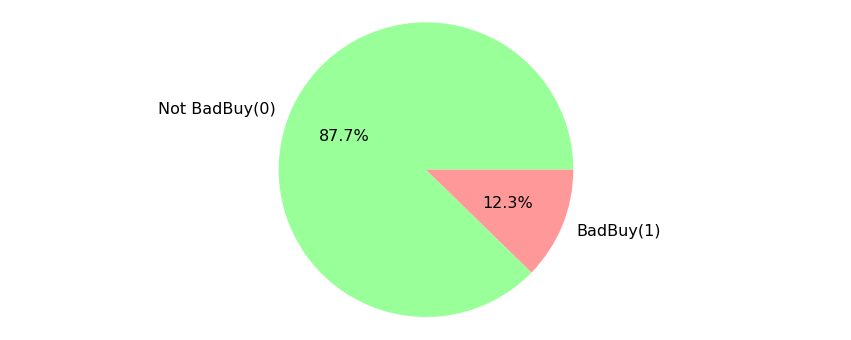

In [7]:
# Get an idea of target category: IsBadBuy
plt.figure(figsize=(15,6))
badbuy_share = df_train["IsBadBuy"].value_counts()
mylabel=["Not BadBuy(0)","BadBuy(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(badbuy_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");

#### Note target categories are strongly imbalanced.
The <a href="https://encord.com/blog/an-introduction-to-balanced-and-imbalanced-datasets-in-machine-learning#:~:text=The%20problem%20with%20a%20model%20trained%20on%20imbalanced%20data%20is%20that%20the%20model%20learns%20that%20it%20can%20achieve%20high%20accuracy%20by%C2%A0%20consistently%20predicting%20the%20majority%20class%2C%20even%20if%20recognizing%20the%20minority%20class%20is%20of%20equal%20or%20more%20importance%20when%20applying%20the%20model%20to%20a%20real%2Dworld%20scenario.%C2%A0">problem</a> with a model trained on imbalanced data is that the model learns that it can achieve high accuracy by  consistently predicting the majority class, even if recognizing the minority class is of equal or more importance when applying the model to a real-world scenario.

In [8]:
# Check the percentage of the missing values
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
PRIMEUNIT,95.32
AUCGUART,95.32
WheelType,4.35
WheelTypeID,4.34
Trim,3.23
MMRCurrentAuctionAveragePrice,0.43
MMRCurrentRetailCleanPrice,0.43
MMRCurrentRetailAveragePrice,0.43
MMRCurrentAuctionCleanPrice,0.43
MMRAcquisitionAuctionAveragePrice,0.02


As can be seen above, more than 95% values of 'PRIMEUNIT' and 'AUCGUART' are missing. This coulmns can be ignored for the analysis.

In [9]:
# Function dropRemarks
drop_cols = pd.DataFrame(columns=['Drop Remarks'])
def dropRemarks(df,col,remark):
    '''
    Function dropRemarks collects all columns which are going
    to be dropped in this analysis. It provides their related remakrks.
    Input:  DataFrame, column name as strng, Remark as string
    output: Dataframe 
    '''
    if col not in drop_cols.index.tolist():
        new_drop = pd.DataFrame(remark,index =[col], columns=['Drop Remarks'])
        return drop_cols.append(new_drop)

In [10]:
# Apply dropRemarks for PRIMEUNIT and AUCGUART
drop_cols = dropRemarks(drop_cols,'PRIMEUNIT','More than 95% of data is missing')
drop_cols = dropRemarks(drop_cols,'AUCGUART','More than 95% of data is missing')
drop_cols = dropRemarks(drop_cols,'RefId','Less likely to contribute the predictability of the model')

drop_cols

,Drop Remarks
PRIMEUNIT,More than 95% of data is missing
AUCGUART,More than 95% of data is missing
RefId,Less likely to contribute the predictability o...


In [11]:
# Correlation heatmap
# Colormap: Most negative correlations (dark-blue) to most positive correlation (dark red)
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
VehYear,1.000000,-0.957957,-0.283719,0.581146,0.532927,0.581191,0.539230,0.590820,0.548426,0.598490,0.558669,0.349965,-0.268696
VehicleAge,-0.957957,1.000000,0.319794,-0.565690,-0.518810,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.312329,0.259310
VehOdo,-0.283719,0.319794,1.000000,-0.017022,0.024617,0.031306,0.063165,-0.028568,0.012107,0.015811,0.048005,-0.062008,0.411718
MMRAcquisitionAuctionAveragePrice,0.581146,-0.565690,-0.017022,1.000000,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.789840,-0.050417
MMRAcquisitionAuctionCleanPrice,0.532927,-0.518810,0.024617,0.990347,1.000000,0.902718,0.918242,0.923610,0.932114,0.860716,0.871203,0.781516,-0.020644
MMRAcquisitionRetailAveragePrice,0.581191,-0.460854,0.031306,0.910391,0.902718,1.000000,0.990201,0.851647,0.849407,0.913108,0.906054,0.746126,-0.053444
MMRAcquisitonRetailCleanPrice,0.539230,-0.426382,0.063165,0.910187,0.918242,0.990201,1.000000,0.846914,0.855689,0.903188,0.906810,0.744966,-0.026933
MMRCurrentAuctionAveragePrice,0.590820,-0.575607,-0.028568,0.937817,0.923610,0.851647,0.846914,1.000000,0.990329,0.915073,0.912231,0.778738,-0.056798
MMRCurrentAuctionCleanPrice,0.548426,-0.532505,0.012107,0.932492,0.932114,0.849407,0.855689,0.990329,1.000000,0.908669,0.921536,0.775100,-0.028131
MMRCurrentRetailAveragePrice,0.598490,-0.504062,0.015811,0.871755,0.860716,0.913108,0.903188,0.915073,0.908669,1.000000,0.989760,0.756816,-0.058025


Correlation is a very useful technique to get rid of unecessary columns from our dataset that don't affect our target.
The Pearson correlation heatmap above gives us an idea about covariance in the dataset. From what we can see the cost variables ar ehighly correlated, we will make a note of this and investigate whether we need to drop these later.

In [ ]:
def simpleBarPlot(df,col,n,m,title):
    '''
    Function simpleBarPlot: 
    Output: Two bar plots - normilized and not normilized
    Input:  DataFrame, Column name, n:m: subplot dimension
           ,Plot Title 
    
    '''
    display(pd.crosstab(columns=df[col], index=df['IsBadBuy']))    
    print('\n################# Plot ',title,' #################')
    print('\n################# Number of unique values: ',
          df[col].nunique(),'#################\n')
    fig, ax = plt.subplots(nrows=n,ncols=m,figsize=(20,12))
    
    freq = pd.crosstab(index=df[col],
                               columns=df['IsBadBuy'], normalize='index')
    freq.plot(kind='bar',ax=ax[0],legend=False,figsize=(20,6),fontsize=16);
   
    count_plot = pd.crosstab(index=df[col],
                           columns=df['IsBadBuy'])    
    count_plot.plot(kind='bar',ax=ax[1],legend=False,figsize=(20,6),fontsize=16);
    
    
    ax[0].set_title(title, fontsize=20)
    ax[0].set_xlabel(col, fontsize=16)
    ax[0].set_ylabel('Frequency', fontsize=16)
    ax[0].legend(labels=['No','Yes'], title= 'Lemon car')
    
    ax[1].set_title(title, fontsize=20)
    ax[1].set_xlabel(col, fontsize=16)
    ax[1].set_ylabel('Count', fontsize=16)
    ax[1].legend(labels=['No','Yes'], title= 'Lemon car')
    fig.tight_layout();    

In [ ]:
def simpleHistPlot(df,col,title,density):
    '''
    Function simpleHistPlot: 
    Output: Two Histogram plots - normilized and not normilized
    Input:  DataFrame, Column name, n:m: subplot dimension
           , Plot Title   
    
    '''
   # display(df.groupby(('IsBadBuy')[col].count())) 
    fig, ax = plt.subplots(figsize=(10,6))
    df.groupby('IsBadBuy')[col].plot(kind='hist',legend=True,
                                     figsize=(20,6),fontsize=16,
                                      alpha=0.6, density=density);  
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.legend(labels=['No','Yes'], title= 'Lemon cars')

In [ ]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'Model',2,1,'Vehicle Model')

In [ ]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'SubModel',2,1,'Vehicle Sub-Model')

In [ ]:
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Model','Too many distincts values')
drop_cols = dropRemarks(drop_cols,'SubModel','Too many distincts values')
drop_cols

In [ ]:
# Simple Bar plot for vehicle model which has the most unique values
simpleBarPlot(df_train,'Auction',1,2,'Auction provider')

In [ ]:
# Investigate VehYear and VehicleAge

# Check the correlation between Year of Manufacture
# of the vehicle Age of the car at the time of the auction
display(df_train[['VehYear','VehicleAge']].corr())

simpleBarPlot(df_train,'VehicleAge',1,2,'VehicleAge')

# Note: AS can be seen, the older the vehicle, more number of defected vehicle
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'VehYear','96% Correlation with VehicleAge')
drop_cols

In [ ]:
ax = df_train.groupby('VehicleAge')['IsBadBuy'].mean().plot(figsize=(8,6));
ax.set_xlabel('VehicleAge', fontsize=16);
ax.set_ylabel('Frequency of BadBuy', fontsize=16);
ax.set_title('Vehicle Age Vs Is BadBuy', fontsize=16 );

#### Again, as expected, we see that vehicle age is strongly indicative of a bad buy.
#### Let's look at how the vehicle manufacturer is related to the probability of a bad buy:

In [ ]:
#simpleBarPlot(df_train,'Make','Make')
simpleBarPlot(df_train,'Make',1,2,'Company')

#### Dogde, Ford, Chevrolet and Chrysler cars account for the most listed as well as most bad buys. That makes sense. If a company has more listings, it will as well have higher bad buys.

In [ ]:
#simpleBarPlot(df_train,'Make','Make')
simpleBarPlot(df_train,'Trim',2,1,'Trim')

In [ ]:
# Note: Too many different distinct Trim values. 
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Trim','Too many distinct values')
drop_cols

In [ ]:
# Investigate Color
simpleBarPlot(df_train,'Color',1,2,'Color')

In [ ]:
# Note: Too many different distinct Trim values. 
# Update the drop columns names
drop_cols = dropRemarks(drop_cols,'Color','The effect is too suspicious!')
drop_cols

In [ ]:
# Plot Transmission
simpleBarPlot(df_train,'Transmission',1,2,'Transmission')

In [ ]:
simpleBarPlot(df_train,'WheelTypeID',2,1,'WheelTypeID')

In [ ]:
drop_cols = dropRemarks(drop_cols,'WheelTypeID','Redundant, as WheelType is available!')
drop_cols

Let's look at how the WheelType is related to the probability of a bad buy


In [ ]:
simpleBarPlot(df_train,'WheelType',1,2,'WheelType')

In [ ]:
# Carmilage = Kms driven / Fuel consumed
simpleHistPlot(df_train,'VehOdo','Mileage of the vehicle',False)


Plot odometer reading vs WarrantyCost

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_train, x='VehOdo',y='WarrantyCost',hue='IsBadBuy');
plt.xlabel('VehOdo', fontsize=16);
plt.ylabel('WarrantyCost', fontsize=16);
plt.legend(title='IsBadBuy', fontsize=16);
plt.title( 'Odometer reading vs WarrantyCost');

Plot the manufacturer's country

In [ ]:
simpleBarPlot(df_train,'Nationality',1,2,'Nationality')

Identifies if the manufacturer is one of the top three American manufacturers

In [ ]:
display(pd.crosstab(index=df_train['TopThreeAmericanName'],columns=df_train['Nationality'])) 
display(pd.crosstab(index=df_train['Make'],columns=df_train['Nationality'])) 
simpleBarPlot(df_train,'TopThreeAmericanName',1,2,'TopThreeAmericanName')

The size category of the vehicle (Compact, SUV, etc.)

In [ ]:
simpleBarPlot(df_train,'Size',1,2,'Size')

Pair Plot of Acquisition costs

In [ ]:
mmr_cols = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice',
           'MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','IsBadBuy','VehBCost']

ax=sns.pairplot(df_train[mmr_cols], hue="IsBadBuy",corner=True);
ax.fig.suptitle("Pair Plot of Acquisition costs");

Distribution of datapoints indentified as lemon cars (BadBuy) should be considered. Thses datapoints even seem like outliers sgould be kept and considered since they have important information (is BadBuy, as target of prediction). 

In [ ]:
drop_cols = dropRemarks(drop_cols,'MMRCurrentAuctionCleanPrice','About 99% correlation with MMRCurrentAuctionAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRCurrentRetailCleanPrice','About 99% correlation with MMRCurrentRetailAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRAcquisitionAuctionCleanPrice','About 99% correlation with MMRAcquisitionAuctionAveragePrice')
drop_cols = dropRemarks(drop_cols,'MMRAcquisitonRetailCleanPrice','About 99% correlation with MMRQcquisitionRetailAverageprice')
drop_cols

Unique number assigned to the buyer that purchased the vehicle

In [ ]:
simpleBarPlot(df_train,'BYRNO',1,2,'BYRNO')
drop_cols = dropRemarks(drop_cols,'BYRNO','Unique Identification Number ')
drop_cols

In [ ]:
simpleBarPlot(df_train,'VNZIP1',2,1,'VNZIP1')

#### State where the the car was purchased

In [ ]:
simpleBarPlot(df_train,'VNST',2,1,'VNST')

In [ ]:
# Update drop_cols data frame
drop_cols = dropRemarks(drop_cols,'VNZIP1','Too many distinct values ')
drop_cols = dropRemarks(drop_cols,'PurchDate','Too many distinct values ')

drop_cols

Acquisition cost paid for the vehicle at time of purchase

In [ ]:
simpleHistPlot(df_train,'VehBCost','Original cost in US dollars paid for the vehicle at the time of purchase',False)

In [ ]:
# create new variable essentially rounding the vehicle cost to the last two digits
df_cost_bb = df_train[['VehBCost','IsBadBuy']]
df_cost_bb['RoundVehBCost'] = round(df_cost_bb['VehBCost'],-2)


# plot the rounded vehicle cost vs. IsBadBuy

plt.figure(figsize=(8,6))
df_cost_bb.groupby('RoundVehBCost').agg([np.mean,np.size])['IsBadBuy'].query('size > 250')['mean']\
                                   .plot(title = "RoundVehBCost Vs IsBadBuy");
plt.xlabel('RoundVehBCost', fontsize=16);

We see that, as intuitively expected, the vehicle age increases the probability of a car being a bad buy, while the vehicle cost decreases this probability.

#### Identifies if the vehicle was originally purchased online

In [ ]:
simpleBarPlot(df_train,'IsOnlineSale',1,2,'IsOnlineSale')

## Cost of the guarantee for a period of 36 months

In [ ]:
simpleHistPlot(df_train,'WarrantyCost','WarrantyCost',True)

### How are the numerical values distributed, are there outliers?

In [ ]:
desired_num_cols = set(num_cols).difference(drop_cols.index.to_list())
desired_num_cols

In [ ]:
# Boxplots or histograms relevant columns
# Find outliers in data using a box plot
col1= ['VehBCost','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice','MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice']
col2 = ['VehOdo']
col3=['VehicleAge']
col4=['WarrantyCost']
fig, ax = plt.subplots(4,1,figsize=(18,22))
ax[0] = sns.boxplot(data=df_train[col1],linewidth=0.5, ax=ax[0]);
ax[0].set_title('Distribution of Costs', fontsize=14)

ax[1] = sns.boxplot(data=df_train[col2], orient="h",linewidth=0.5, ax=ax[1]);
# xtick, label, and title
ax[1].set_title('Distribution of VehOdo', fontsize=14)
ax[1].set_xlabel('VehOdo', fontsize=20)

ax[2] = sns.boxplot(data=df_train[col3], orient="h",linewidth=0.5, ax=ax[2]);
# xtick, label, and title
ax[2].set_title('Distribution of VehicleAg', fontsize=14)
ax[2].set_xlabel('VehicleAge', fontsize=20)


ax[3] = sns.boxplot(data=df_train[col4], orient="h",linewidth=0.5, ax=ax[3]);
# xtick, label, and title
ax[3].set_title('Distribution of WarrantyCost', fontsize=14)
ax[3].set_xlabel('WarrantyCost', fontsize=20)

plt.tight_layout();
sns.set(style="darkgrid")

# 5) Train Test Validation Split

In this project, we need both the training and the test and target data:

#### * Trainingsdaten
    * Train model(model fitting)
    * Find the best hyperparameters with a grid search
    * Determine the model quality with cross-validation

#### * Test data
    * Evaluate the trained model

#### * Target dates
    * Use the trained model to predict target values where none are known

It is not specified the test data yet. Therefore, at this point, data is splited into a training and testing set and we proceed with the training set as if that were all the data you have available. When we have finished building the model, we can use the test set to simulate what happens when new data enters our data pipeline, for example new cars are offered on auction platforms.

In [ ]:
# Perform train-test-split
from sklearn.model_selection import train_test_split


# Split off target from features
target = df_train.loc[:, 'IsBadBuy']
features = df_train.drop(columns=['IsBadBuy'])

# Set apart some data for testing
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            random_state=42, test_size=0.1)

We now have a training dataset. We can use this to create new features and to train the building blocks of your model.

# 6) Data Preparation

The goal of data preparation is to find a way to clean the data sets for our model (data cleaning) and to bring them into a format that the model can read (data type transformation). When these steps have been completed, we can set about selecting a training set that is as representative as possible (sampling).

In [ ]:
# Copy created feature train and feature test for further comparision
features_train_init = features_train.copy()
features_test_init = features_test.copy()

In [ ]:
# Descriptive statistics of features train dataset
features_train.describe()

We can reduce the memory required by changing the dtype of the columns of a pandas DataFrame. For example, by default integers are stored as 'int64'. If we convert them to 'uint8', they only need an eighth of the original storage space. ('uint8' can represent values from 0 to 255 and 'uint16' already values up to 65535).

# 7) Data Imputation

As can be seen from EDA part, there are relatively many missing values in the data. This also applies to the test and target data. For the test and target data, we should classify each data point. So we should not remove a data point from them because of missing or improbable values. Instead, we could replace the missing values or remove features with many missing values.

In [ ]:
percent_missing = features_train.isnull().sum() * 100 / len(features_train)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

In [ ]:
def clean_data(df_init,df,col,imput_value):
    '''
    Function clean_data does simple data imputation
    for categorical data.
    Input:
        Initial dataframe, dataframe(modified)
        column name, imputation value as string
    Output:
        Modified DataFrame
    TODO: from sklearn.impute import SimpleImputer
    '''
    # Data Type Transformation
    if col == 'VehicleAge' or col == 'IsOnlineSale':
        df[col] = df[col].astype('uint8')
        return df       
    
    # Data Imputation
    display(df_init[col].unique())
    display(df_init[col].isnull().sum())

    if col== 'Transmission':
        df[col].replace("Manual", "MANUAL", inplace=True)
    df[col].fillna(value=imput_value,inplace=True)
    display(df[col].unique())
    display(df[col].isnull().sum())        
    return df  

In [ ]:
def type_transform(df):
    '''
    Function type_transform tranforms data type for features defined
    as inside the function.
    Input:
        DataFrame
    Output:
        Modified DataFrame
    '''
    category_cols=["Auction", "Make", "WheelType", "Transmission", "Size",
    "IsOnlineSale", "Nationality", "TopThreeAmericanName","VNST"]
    for col in category_cols:
        df[col]=df[col].astype("category")        
        
    # Convert data type int64 to int8
    # int_cols = list(features_train.select_dtypes(include='int64'))
    # int8: -128 to 127	Signed 8-bit integer
    # Two columns whose data type can be trnasformed. See their plausibility ranges
    df['VehicleAge'] = df['VehicleAge'].astype('uint8')
    df['IsOnlineSale'] = df['IsOnlineSale'].astype('uint8')
    return df

In [ ]:
def fillDataGaps(df,col):
    '''
    Function fillDataGaps fill data gaps (missing data)
    with the median value of the whole data.
    Input: 
        df: dataframe, 
        col: column name as string#
    Output: 
        df: Modified DataFrame 
    '''
    df[col] = df[col].fillna(df[col].median())
    
    return df     

In [ ]:
def dropUndesiredFeatures(df,drop_cols):
    '''
    Function dropUndesiredFeatures drops undesired 
    columns from the DataFrame.
    Input:
        df: DataFrame
        drop_cols:DataFrame which provide information
        of columns needed to be droped.
    Output:
        df_cleaned: Cleanded DataFrame
    '''
    drop_cols_names = drop_cols.index.to_list()
    df_cleaned = df.drop(drop_cols_names,axis=1)
    return df_cleaned

In [ ]:
# Apply cleaning and data imputation
features_train = clean_data(features_train_init,features_train,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_train = clean_data(features_train_init,features_train,'Nationality','OTHER')
features_train = fillDataGaps(features_train,'MMRAcquisitionAuctionAveragePrice')
features_train = fillDataGaps(features_train,'MMRAcquisitionRetailAveragePrice')
features_train = fillDataGaps(features_train,'MMRCurrentAuctionAveragePrice')
features_train = fillDataGaps(features_train,'MMRCurrentRetailAveragePrice')
features_train = fillDataGaps(features_train,'VehBCost')
features_train = type_transform(features_train)

# Apply data cleaning
features_train_cleaned = dropUndesiredFeatures(features_train,drop_cols)
display(drop_cols)
display(features_train_cleaned.isna().sum())
display(features_train_cleaned.head(),features_train_cleaned.info())
features_train_cleaned.shape

# 8) Deal with outliers

Are there impossible values that just need to be sorted out in the training set?

If you choose to delete outliers. Then only do this in the training set. And don't add this step to your pipeline or cleaning function. Otherwise, you may not be able to get a prediction for every value in features_aim at project completion.

In [ ]:
# Identifying outliers and deal with them
# Outliers analysis
def find_outliers(df):
    '''
    Function find_outliers finds the outlires of data
    using statistical methos interquartile range (IQR)
    Input: 
        DataFrame
    OutPut:
        OutlierRange 
    '''
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outlire_range = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outlire_range

In [ ]:
# Find number of outliers, maximum and minimum
# value of it for each column
# Initialize data frame for collecting outliers
df_outliers = pd.DataFrame(index = ['Count','Max','Min'])
for col in num_cols:
    outliers = find_outliers(features_train[col])
    df_outliers.loc['Count',col] = len(outliers)
    df_outliers.loc['Max',col] = outliers.max()
    df_outliers.loc['Min',col] = outliers.min()
df_outliers    

In [ ]:
# Check for outliers
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.scatterplot(data=df_train, x = 'MMRAcquisitionAuctionAveragePrice',
                 y  = 'MMRAcquisitionRetailAveragePrice',hue="IsBadBuy",ax=ax[0]);
sns.scatterplot(x='VehBCost', y='VehOdo', data=df_train,  hue='IsBadBuy',ax=ax[1]);

Outliers visually detected in diagram Acquisition vs Odometer can not be droped as they are related to BadBays and these important information should be kept for our prediction later. 

# 9) Resample
As you may have noticed, the target categories in the dataset are very unbalanced. So it may be necessary to [resample](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) your training dataset.
Most machine learning algorithms assume that the data is evenly distributed within classes. In the case of class imbalance problems, the extensive issue is that the algorithm will be more biased towards predicting the majority class (no heart stroke in our case). The algorithm will not have enough data to learn the patterns present in the minority class (heart stroke). This technique is used to upsample or downsample the minority or majority class. When we are using an imbalanced dataset, we can oversample the minority class using replacement. This technique is called oversampling. In this project we use this method of resampling. 

[Random Oversampling ](https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf#:~:text=github.com-,Random%20Oversampling,-Random%20Oversampling%20includes)includes selecting random examples from the minority class with replacement and supplementing the training data with multiple copies of this instance, hence it is possible that a single instance may be selected multiple times.

![](https://editor.analyticsvidhya.com/uploads/95268oversample.JPG)

### Applay oversamoling to the train data

In [ ]:
# Display the count of target value
display(pd.crosstab(index=target_train,
            columns='count'))
sns.countplot(target_train);

In [ ]:
#1. initiatiate 
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

#2. fit and resample
features_train_cleaned, target_train = oversampler.fit_resample(features_train_cleaned, target_train)

#show classes
display(pd.crosstab(index=target_train,
            columns='count'))
sns.countplot(target_train);

# 10) Modeling
## Build a simple Baselinemodel
Before we devote yourself to the creation and selection of new features, we should first see from which point we start our efforts and create a first simple model without any hyperparameter optimization. This way we can always check afterwards whether the following steps in the model optimization bring an improvement. It is best to create a pipeline that not only models, but also encodes non-numerical features. 

In [ ]:
# Import regured libraries for modeling and feature engineering steps.
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pdpipe as pdp
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Apply data cleaning and imputation for features_test 
features_test = clean_data(features_test_init,features_test,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Nationality','OTHER')
print('--------------------------------------------------------------------------------------------')

# Fill data gaps
features_test = fillDataGaps(features_test,'MMRAcquisitionAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRAcquisitionRetailAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentRetailAveragePrice')
features_test = fillDataGaps(features_test,'VehBCost')

# Drop undesired columns
features_test_cleaned = dropUndesiredFeatures(features_test,drop_cols)
display(features_test_cleaned.isna().sum())
display(features_test_cleaned.head(),features_test_cleaned.info())

# Apply data type transformation
features_test_cleaned = type_transform(features_test_cleaned)

### 1- Define numeric features (num_cols) and categorical features (cat_cols)

In [ ]:
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [ ]:
# Define numerical and categorical columns
num_cols =['VehicleAge','VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice',
           'MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice','VehBCost','WarrantyCost']

cat_cols = ['Auction','Make','Transmission','WheelType','Nationality','Size',
            'TopThreeAmericanName','VNST','IsOnlineSale']

# Define num_cols and cat_cols for base-model
num_cols_bl =['VehicleAge','VehOdo']
cat_cols_bl = ['Auction']

### 2- Select the algorithm for the baseline model and instantiate it as a model

In [ ]:
features_train_cleaned[num_cols_bl+cat_cols_bl]

In [ ]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(class_weight="balanced",max_iter=1000)

# Build pipeline
# Create preprocessing pipeline
preprocessor_baseline = ColumnTransformer([('num', StandardScaler(), num_cols_bl),
                                  ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols_bl)])
model_baseline = Pipeline([('pre', preprocessor_baseline),('clf', model_log)])

# fit pipeline on cleaned (and filtered) training set
model_baseline.fit(features_train_cleaned[num_cols_bl+cat_cols_bl], target_train)

In [ ]:
# predict and evaluate on test set
# features_train, features_test, target_train, target_test 
target_test_pred = model_baseline.predict(features_test_cleaned)
precision = precision_score(target_test, target_test_pred)
recall= recall_score(target_test, target_test_pred)
f1_scr = f1_score(target_test, target_test_pred)

scores = {'name': 'model_baseline_logreg',
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }
# Save model results
model_results=[]
model_results.append(scores)
model_results = pd.DataFrame(model_results)
model_results

# 11) Feature Engineering
## Dimensionality Reduction


In [ ]:
def engineer_features_final(features,cols):
    '''
    Function engineer_features to convert each categorical value 
    into a new categorical column and assign a binary value of 1 or 0 to 
    those columns. Each integer value is represented as a binary vector
    
    input: 
        features: DataFrame of features
        cols:  list of categorical data
    output: 
        Onehot encoded DataFrame
    '''         
    # OneHotEncoding train
    onehot = pdp.OneHotEncode(columns=cols, drop_first=False)
    features = onehot.fit_transform(features)
    
    return features

In [ ]:
# Apply function engineer_features_final
features_ohe= engineer_features_final(features_train_cleaned,cat_cols)
features_test_ohe = engineer_features_final(features_test_cleaned,cat_cols)
features_ohe

In [ ]:
def scale_pca(features):
    '''
    Function scale_pca applay dimension reduction based on the
    Principle Component Analysis.
    Input:
        DataFrame
    Output:
        
    '''
    # Features with high correlation with eachother
    col_correlated = ['MMRAcquisitionAuctionAveragePrice','MMRAcquisitionRetailAveragePrice',
           'MMRCurrentAuctionAveragePrice','MMRCurrentRetailAveragePrice','VehBCost']    
   
    keep_cols = [x for x in features.columns.tolist() if x not in col_correlated]
    
    # Define pipeline
    std_pca = Pipeline([('std', StandardScaler()), ('pca', PCA(n_components=2))])  
    col_dropper = ColumnTransformer([('drop_unused_cols', 'passthrough', keep_cols)])
   
    # Define the final transformer
    corr_transformer = ColumnTransformer(transformers=[('pca', std_pca, col_correlated)], remainder=col_dropper)
    # array erzeugen
    train_pca = corr_transformer.fit_transform(features)
    
    # Add new column names to other existing column names 
    col_names = ['price_cost_pca1','price_cost_pca2'] + keep_cols
    
    # Make final datafrime
    features_pca = pd.DataFrame(train_pca, columns=col_names)     
    

    return features_pca

In [ ]:
features_ohe_std_pca = scale_pca(features_ohe)
features_test_ohe_std_pca = scale_pca(features_test_ohe)
features_ohe_std_pca

In [ ]:
# Difference due to different values orginated in train test split.. 
# For example in feature_test there is no nan value but in feature_train there nan.
drop_diff = features_ohe_std_pca.columns.difference(features_test_ohe_std_pca.columns).tolist()
features_ohe_std_pca.drop(drop_diff,axis=1,inplace=True)
features_ohe_std_pca.head()

# 12) Feature Selection
<a href="https://medium.com/fiverr-engineering/feature-selection-beyond-feature-importance-9b97e5a842f#:~:text=Why%20is%20it%20SO%20IMPORTANT%20to%20do%20Feature%20Selection%3F# /">Feature selection</a> is used to make the process more accurate. It also increases the prediction power of the algorithms by selecting the most critical variables and eliminating the redundant and irrelevant ones. This is why feature selection is important. Removing the noisy features will help with memory, computational cost and the accuracy of the model. Also, by removing features, it will help to avoid the overfitting of your model.

## Feature Selection Using Random forest


In [ ]:
#initate Model
from sklearn.ensemble import RandomForestClassifier
model_rndforest = RandomForestClassifier(class_weight="balanced", random_state=0)

#fit
model_rndforest.fit(features_ohe_std_pca,target_train)

#save results
feature_results=[]

#predict
target_test_pred = model_rndforest.predict(features_test_ohe_std_pca)

#evaluate
recall = recall_score(target_test,target_test_pred)
precision = precision_score(target_test,target_test_pred)
f1_scr = f1_score(target_test,target_test_pred)

#save
scores = {'name': "model_rndforest",
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }
feature_results.append(scores)

#show results
feature_results = pd.DataFrame(feature_results)
feature_results

## Feature importance using Meta-transformer based on importance weights

<a href="https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f">SelectFromModel</a> will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want.

In [ ]:
# ImportSelectFromModel as meta-transformer for selecting features based on importance weights.
# It automatically selects the features.

sel = SelectFromModel(model_rndforest)
sel.fit(features_ohe_std_pca, target_train)

# To see which features are important we can use get_support method on the fitted model.
# It will return an array of boolean values. True for the features whose importance
# is greater than the mean importance and False for the rest.
selected_feat = features_ohe_std_pca.columns[(sel.get_support())]
selected_imp_values  = sel.estimator_.feature_importances_[(sel.get_support())]
importance_df_sel = pd.DataFrame(selected_feat)

# Initialize important features data frame and plot them
importance_df = pd.DataFrame({
    'feature': selected_feat,
    'importance': selected_imp_values
}).sort_values('importance', ascending=False)

display(importance_df)
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df,palette='husl',x='importance', y='feature');

In [ ]:
# feature_selection
features_ohe_std_pca_sel = features_ohe_std_pca[selected_feat]
features_test_ohe_std_pca_sel = features_test_ohe_std_pca[selected_feat]

In [ ]:
#initate Model
from sklearn.ensemble import RandomForestClassifier
model_rndforest = RandomForestClassifier(class_weight="balanced", random_state=0)

#fit
model_rndforest.fit(features_ohe_std_pca_sel,target_train)

#predict
target_test_pred = model_rndforest.predict(features_test_ohe_std_pca_sel)

#evaluate
recall = recall_score(target_test,target_test_pred)
precision = precision_score(target_test,target_test_pred)
f1_scr = f1_score(target_test,target_test_pred)

#save
scores= {'name': "model_rndforest_selected_features",
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
             }
feature_results = feature_results.append(scores,ignore_index=True)

#show results
feature_results = feature_results.set_index('name')
feature_results

It seems that selecting just the first 15 important features did not improve the model scores. 

# 13) Train model
After preparing data and deciding on features we can proceed with building classification mdels.  
Building a model is an iterative process. Typically, we go through the following steps when choosing the model:
* Select features
* Scaling and dimension reduction (optional)
* Hyperparameter selection and training
* Validation of the model


In [ ]:
# Modify columns names after PCA
num_cols =['VehicleAge','VehOdo','price_cost_pca1','price_cost_pca2','WarrantyCost']
cat_cols = ['Auction','Make','Transmission','WheelType','Nationality','Size',
            'TopThreeAmericanName','VNST','IsOnlineSale']

 ## Logistic Regression

In [ ]:
# Initiate model
model_logreg = LogisticRegression(class_weight='balanced')

# Create Pipeline
pipeline_logreg = Pipeline([("scaler",StandardScaler()),
                           ("model_logreg", model_logreg)])

# Fit pipeline on cleaned training set
pipeline_logreg.fit(features_ohe_std_pca, target_train)

# Define hyperparameters range
# parameter grid, # l1 lasso l2 ridge
search_space_logreg = {
            'model_logreg__penalty' : ['l1','l2'], 
            'model_logreg__C'       : np.geomspace(0.001,1000,10),
            'model_logreg__solver'  : ['newton-cg', 'lbfgs'],
              }

# Perform grid search
grid_logreg = GridSearchCV(estimator=pipeline_logreg,
                            param_grid=search_space_logreg,
                            scoring='f1',
                            cv=3, n_jobs=-1)
grid_logreg.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_logreg)}:\n')
print(f'Mean (F1): {grid_logreg.best_score_}')
print(grid_logreg.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_logreg.best_params_)

## Random Forest Classifier

Please note that role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.Random Forest is a tree-based model and hence does not require feature scaling.

In [ ]:
# Initiate model
model_randfst = RandomForestClassifier(class_weight='balanced',n_estimators=50, random_state=42)

# Define hyperparameters range
search_space_randfst = {"max_depth": [5, 8, 10, 15, 18, 20, 22, 23, 25, 28, 40],
                        "min_samples_leaf": [1, 3, 5, 7, 10, 50, 100, 200]}

# Perform grid search
grid_randfst = GridSearchCV(estimator=model_randfst,
                        param_grid=search_space_randfst,
                        scoring='f1',
                        cv=5) 
grid_randfst.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_randfst)}:\n')
print(f'Mean (F1): {grid_randfst.best_score_}')
print(grid_randfst.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_randfst.best_params_)   

 ## KNeighborsClassifier

In [ ]:
# Initiate model
model_knn = KNeighborsClassifier()

# Make Pipeline
pipeline_knn= Pipeline([("scaler",StandardScaler()),
                           ("model_knn", model_knn)])

# Define hyperparameters range
k = [10, 50, 100]
search_space_knn = {'model_knn__n_neighbors': k,  
                    'model_knn__weights': ['uniform', 'distance'],
                     'model_knn__metric': ['euclidean','manhattan']}

# Perform grid search
grid_knn = GridSearchCV(estimator=pipeline_knn,
                        param_grid=search_space_knn,
                        scoring='f1',
                        cv=3,n_jobs = -1)
grid_knn.fit(features_ohe_std_pca, target_train)

# Model scores
print(f'Training F1-scores for {type(model_knn)}:\n')
print(f'Mean (F1): {grid_knn.best_score_}')
print(grid_knn.best_estimator_)
print('---')
print("tuned hpyerparameters :(best parameters) ",grid_knn.best_params_)

# 14) Evaluate the best classification models
After using  the grid search to get an overview of which models are promising and how well they perform, we should evaluate them again with new test data. We can now use three model quality measures for this evaluation to examine our models in detail. 
We need to decide which metric is most important to us. We can use confusion_matrix() from sklearn.metrics to see exactly how many data points were correctly and incorrectly classified. 

### Again about the metrics:
With our understanding of the problem, we should now consider which metric(s) are best suited to assess the success of our model.
1. Recall: Percentage of vehicles correctly predicted as lemon cars relative to all actual lemon cars.
2. Precision: Percentage of vehicles correctly predicted as lemon cars relative to all correct predictions.
3. F1 Score: Weighted harmonic mean of precision and recall.
Goal: Exclude as many bad purchases of "lemon cars" as possible. Minimize the false negative rate, i.e. the maximum recall.
However, this should not mean that too many good purchases are excluded (minimum false positive).
The false positive rate must not be too high either.
It is important to see which metric is most important to us. 

<b style='color:blue !important;'>The f1 score takes into account both miss rates and is the metric we are looking for. Using confusion_matrix() as below, we      can see exactly how many data points were correctly and incorrectly classified.</b> 

In [ ]:
target_test_pred_logreg = grid_logreg.predict(features_test_ohe_std_pca)    
print('\nPrecision: ', precision_score(target_test, target_test_pred_logreg))
print('Recall: ', recall_score(target_test, target_test_pred_logreg))
print('F1: ', f1_score(target_test, target_test_pred_logreg))
confusion_matrix_logreg= confusion_matrix(target_test, target_test_pred_logreg)
cm = sns.heatmap(confusion_matrix_logreg, annot=True, fmt='d');
cm.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of LogisticRegression');

In [ ]:
target_test_pred_randfst = grid_randfst.predict(features_test_ohe_std_pca)    
print('\nPrecision: ', precision_score(target_test, target_test_pred_randfst))
print('Recall: ', recall_score(target_test, target_test_pred_randfst))
print('F1: ', f1_score(target_test, target_test_pred_randfst))
confusion_matrix_randfst= confusion_matrix(target_test, target_test_pred_randfst)
cm = sns.heatmap(confusion_matrix_randfst, annot=True, fmt='d');
cm.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of RandomForestClassifier')

In [ ]:
target_test_pred_knn = grid_knn.predict(features_test_ohe_std_pca)    
print('\nPrecision: ', precision_score(target_test, target_test_pred_knn))
print('Recall: ', recall_score(target_test, target_test_pred_knn))
print('F1: ', f1_score(target_test, target_test_pred_knn))
confusion_matrix_knn= confusion_matrix(target_test, target_test_pred_knn)
cm = sns.heatmap(confusion_matrix_knn, annot=True, fmt='d');
cm.set(xlabel='Predicted Values', ylabel='Actual Values', title='Results of KNeighborsClassifier')

As can be seen from the confusion matrix above, Random Forest Classifier has a better ability to classify the data showing a better f1 score of 36% compared to other models.

From 7299 cars of test data, it predicts 227 cars as lemon cars (true positive) and 6280 cars as good cars. However, it indicates 607 good cars as lemon cars (false negative) which causes a low recall value. It detects 185 good cars as lemon cars which is not too bad (false positive).

With an overall f1 score of 34.6%, logistic regression is better at recognizing lemon cars and good cars individually but considering errors involved, false positive and false negative, it shows still lower predictability performance.


# 15) Improvements

One of the main challenges of this analysis is feature engineering. Of course, there is no perfect solution or method but there are some points that can be considered for the next steps:
- In this analysis, we used imputed the missing values using the median for numerical values. It would be a good idea to try other methods for data imputation
such as kNN, most frequent, etc. For more details please see [Introduction to Data Imputation](https://www.simplilearn.com/data-imputation-article
        
- Different resampling can be applied. For example, Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model. Please see [here](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c) for more details.
- Ensembling models might be an improvement step. In order for a machine learning model to react quickly to changes in the training data (high variance,           potentially overfitting) without losing stability at the same time (low bias), methods were developed that combine models with each other.
  The hope is that the resulting meta-models will generate better predictions than any individual model that composes them. One can use VotingClassifier from scikeat-learn module. VotingClassifier combines predictions to make the meta-model produce more robust predictions.
- In this analysis, grid search methods were used to find the best hyperparameter for our models. Different optimal sets and combinations of hyperparameters can be implemented to see if it leads to better model performance. 

# 16) Prediction
We can now use our selected model which is Random Forest Classifier for final prediction on available data  features_aim.csv and see  how many purchases in the target dates should not be made?


In [ ]:
features_test = clean_data(features_test_init,features_test,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_test = clean_data(features_test_init,features_test,'Nationality','OTHER')
print('--------------------------------------------------------------------------------------------')
features_test = fillDataGaps(features_test,'MMRAcquisitionAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRAcquisitionRetailAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentAuctionAveragePrice')
features_test = fillDataGaps(features_test,'MMRCurrentRetailAveragePrice')
features_test = fillDataGaps(features_test,'VehBCost')

features_test_cleaned = dropUndesiredFeatures(features_test,drop_cols)
display(features_test_cleaned.isna().sum())
display(features_test_cleaned.head(),features_test_cleaned.info())
features_test_cleaned = type_transform(features_test_cleaned)

In [ ]:
df_aim = pd.read_csv("/kaggle/input/d/iamamir/features-aim/features_aim.csv")

df_aim_init = df_aim.copy()

# Apply cleaning and data imputation
features_aim = clean_data(df_aim_init,df_aim,'TopThreeAmericanName','OTHER')
print('--------------------------------------------------------------------------------------------')
features_aim = clean_data(df_aim_init,df_aim,'Size','SIZE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_aim = clean_data(df_aim_init,df_aim,'WheelType','WHELLTYPE_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_aim = clean_data(df_aim_init,df_aim,'Transmission','TRANSMISSION_UNKNOWN')
print('--------------------------------------------------------------------------------------------')
features_aim = clean_data(df_aim_init,df_aim,'Nationality','OTHER')
features_aim = fillDataGaps(df_aim,'MMRAcquisitionAuctionAveragePrice')
features_aim = fillDataGaps(df_aim,'MMRAcquisitionRetailAveragePrice')
features_aim = fillDataGaps(df_aim,'MMRCurrentAuctionAveragePrice')
features_aim = fillDataGaps(df_aim,'MMRCurrentRetailAveragePrice')
features_aim = fillDataGaps(df_aim,'VehBCost')


# Drop undesired features
features_aim_cleaned = dropUndesiredFeatures(features_aim,drop_cols)

#Feature engineering
features_aim_ohe = engineer_features_final(features_aim_cleaned,cat_cols)
features_aim_ohe_std_pca = scale_pca(features_aim_ohe)

In [ ]:
# create preprocessing pipeline
badbuy_count = sum(grid_randfst.predict(features_aim_ohe_std_pca))
all_buys = len(df_aim)
print(f' According to the selected model (randomForest), {badbuy_count} \
of {all_buys} buys, (almost {round((badbuy_count/all_buys),2)*100}% of all buys), are predicted as BadBuy!')

**According to the selected model (Random Forest Classifries), 792 of 7338 buys, (almost 11.0% of all buys), are predicted as lemon cars (bad buy)!**